<a href="https://colab.research.google.com/github/miczkejedrzej/MNLP-project-1/blob/main/04_Modeling_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Ensemble


In [1]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

train_df = pd.read_json('/content/drive/MyDrive/France_Poland_multilanguage_shared_folder/train_df_complete.json', orient="records", lines=True)
dev_df = pd.read_json('/content/drive/MyDrive/France_Poland_multilanguage_shared_folder/dev_df_complete.json', orient="records", lines=True)

Mounted at /content/drive


In [4]:
'''imports '''
from google.colab import files
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder,MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.utils import to_categorical
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers


from tqdm.auto import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 3.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp311-cp311-linux_x86_64.whl size=4313489 sha256=7220ff229201e8457b8bf056d648600c66df3581b5dfb01ffcda7335cb406ea9
  Stored in directory: /root/.cache/pip/wheels/65/4f/35/5057db0249224e9ab55a513fa6b79451473ceb7713017823c3
Successfully built fasttext


## Import the 3 models

In [ ]:
!pip install huggingface_hub tensorflow --quiet

from huggingface_hub import login, create_repo, upload_folder
import os
import tensorflow as tf
from huggingface_hub import hf_hub_download

# Repo name and model file name
repo_id = "tgarnier067/MNLP-HW1"
model_name_1 = "model_logits_features.keras"
model_name_2 = "model_logits_description.keras"
model_name_3 = "model_logits_photos.keras"

# Download the model from Hugging Face
model_path_1 = hf_hub_download(repo_id=repo_id, filename=model_name_1)
model_path_2 = hf_hub_download(repo_id=repo_id, filename=model_name_2)
model_path_3 = hf_hub_download(repo_id=repo_id, filename=model_name_3)


# Load the .keras model with TensorFlow
model_logits_features = tf.keras.models.load_model(model_path_1)
model_logits_description = tf.keras.models.load_model(model_path_2)
model_logits_photos = tf.keras.models.load_model(model_path_3)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_logits_features.keras:   0%|          | 0.00/8.74M [00:00<?, ?B/s]

model_logits_description.keras:   0%|          | 0.00/9.86M [00:00<?, ?B/s]

model_logits_photos.keras:   0%|          | 0.00/517k [00:00<?, ?B/s]

## model_logits_description

### Prepare the data

In [ ]:
 import fasttext.util
 fasttext.util.download_model('en', if_exists='ignore')  # English
 ft = fasttext.load_model('cc.en.300.bin')

In [ ]:
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt_tab')
porter = PorterStemmer()
stop_words = set(stopwords.words('english'))
from sklearn.preprocessing import normalize


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
'''transforming the descriptions to the embeddings space , adding the oov information'''
def transform_description(description):
  oov_words = 0
  description = nltk.word_tokenize(description)
  description = [word for word in description if word not in stop_words]
  description = [word.lower() for word in description]
  for word in description:
    if word not in ft.words:
      oov_words += 1
  description = " ".join(description)
  description_vector = ft.get_sentence_vector(description)
  description_vector = normalize(description_vector.reshape(1, -1), norm='l2')[0]
  description_vector = np.append(description_vector, oov_words)
  return description_vector

In [ ]:
# Extract text and label in train set
train_texts = train_df['description'].to_list()
train_labels = train_df['label_int'].to_list()

# Extract text and label in dev set
dev_texts = dev_df['description'].to_list()
dev_labels = dev_df['label_int'].to_list()

# Vectorize the texts with fasttext
train_vectors = np.array([transform_description(text) for text in train_texts])
dev_vectors = np.array([transform_description(text) for text in dev_texts])

### Apply the model to the data

In [ ]:
logits_dev_model_descriptions = model_logits_description.predict(dev_vectors)
logits_train_model_description = model_logits_description.predict(train_vectors)

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 199ms/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


In [ ]:
df_train_description = pd.DataFrame(logits_train_model_description, columns=['logit_0', 'logit_1', 'logit_2'])
df_train_description['label'] = train_df['label_int']
dev_df_description = pd.DataFrame(logits_dev_model_descriptions, columns=['logit_0', 'logit_1', 'logit_2'])
dev_df_description['label'] = dev_df['label_int']


In [ ]:
'''sanity check on the dataframe'''
df_train_description.head(10)

,logit_0,logit_1,logit_2,label
0,3.058109,2.589369,-2.483755,0
1,1.345696,3.145509,-2.701565,1
2,0.583880,3.219156,-2.520623,1
3,2.011387,2.479025,-2.594582,1
4,0.641382,4.713881,-2.740190,1
5,0.971917,3.029584,-2.572828,1
6,3.570248,2.144744,-1.809623,0
7,2.008799,2.841348,-2.732523,1
8,0.561219,4.884227,-2.567963,1
9,3.452880,2.558653,-2.165390,0


## model_logits_features

### Prepare the data

In [ ]:
# Get the list of explicatives variables
list_var = ['subclass_depth', 'subclasses', 'instances_of', 'instances_of_up', 'date', 'nb_lang',
       'descr_num_nouns', 'descr_num_verbs',
       'descr_num_adjectives', 'descr_has_location', 'descr_has_ethnic_group',
       'descr_has_event', 'type_cat', 'category_architecture',
       'category_biology', 'category_comics and anime', 'category_fashion',
       'category_films', 'category_food', 'category_geography',
       'category_literature', 'category_media', 'category_music',
       'category_politics', 'category_sports', 'category_transportation',
       'category_visual arts', 'category_combined',
       'main_country_cat'
]

# Create the X and y, train and dev
X_train = train_df[list_var]
y_train = train_df['label_int'].values

X_dev = dev_df[list_var]
y_dev = dev_df['label_int'].values

# Selecting numerical columns from X_train (all of them are int64 or float64)
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Defining pipeline: impute Nan, then scale
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

# Appling pipeline to numeric columns
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols)
])


#adjustin the data to proper format
X_train_processed = preprocessor.fit_transform(X_train)
X_dev_processed = preprocessor.transform(X_dev)

# float cast
X_train_processed = X_train_processed.astype('float32')
X_dev_processed = X_dev_processed.astype('float32')

# One-hot encode labels
y_train_cat = to_categorical(y_train, num_classes=3)
y_dev_cat = to_categorical(y_dev, num_classes=3)

### Apply the model on the data

In [ ]:
logits_dev_model_features = model_logits_features.predict(X_dev_processed)
logits_train_model_features = model_logits_features.predict(X_train_processed)

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


## model_logits_photos

In [ ]:
# transform the data into arrays
train_df['image'] = train_df['image'].apply(lambda x: np.array(x))
dev_df['image'] = dev_df['image'].apply(lambda x: np.array(x))

In [ ]:
# Images normalization
X_train_fill = np.stack(train_df['image'].to_numpy()).astype('float32') / 255.0
y_train_fill = train_df['label']

X_dev_fill = np.stack(dev_df['image'].to_numpy()).astype('float32') / 255.0
y_dev_fill = dev_df['label']

In [ ]:
# Apply the model
logits_dev_model_photos = model_logits_photos.predict(X_dev_fill)
logits_train_model_photos = model_logits_photos.predict(X_train_fill)

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


## Ensemble model


here we try to combine two classifiers, one basing on the neural network working on features extracted frrom the wikidata/wikipedia, and the second one basing on the neural network working on the embedding representation of the description of the wikipedia/wikidata entities. We combine them with a meta lerner that as training set  takes the logits for each label from both of the trained base neural networks, achieved on the train set. And the validation are the logits of these two networks acquired by predcition on the validation set.

### Build and fit the ensemble model

In [ ]:
# Prepare the data
train_labels = df_train_description['label']
dev_labels = dev_df_description['label']

train_labels_nn = to_categorical(train_labels, num_classes=3)
dev_labels_nn = to_categorical(dev_labels, num_classes=3)

train_vectors = np.concatenate((logits_train_model_description, logits_train_model_features), axis=1)
train_vectors = np.concatenate((train_vectors, logits_train_model_photos), axis=1)
dev_vectors = np.concatenate((logits_dev_model_descriptions, logits_dev_model_features), axis=1)
dev_vectors = np.concatenate((dev_vectors, logits_dev_model_photos), axis=1)

# Build early stop and reduce lr condition
early_stop = callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)


# Define the model
model_Ensemble = models.Sequential([
    layers.Input(shape=(9,)),
    layers.Dense(16, kernel_regularizer=regularizers.l2(1e-4)),
    LeakyReLU(alpha=0.1),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(8, kernel_regularizer=regularizers.l2(1e-4)),
    LeakyReLU(alpha=0.1),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(3, activation='softmax')
])

# Compile and train
model_Ensemble.compile(optimizer=Adam(learning_rate=3e-4),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

history = model_Ensemble.fit(
    train_vectors, train_labels_nn,
    validation_data=(dev_vectors, dev_labels_nn),
    epochs=200,
    batch_size=64,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


98/98 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - accuracy: 0.4623 - loss: 1.0945 - val_accuracy: 0.5667 - val_loss: 0.9863 - learning_rate: 3.0000e-04
Epoch 2/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6122 - loss: 0.8487 - val_accuracy: 0.6133 - val_loss: 0.8819 - learning_rate: 3.0000e-04
Epoch 3/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7126 - loss: 0.6919 - val_accuracy: 0.6333 - val_loss: 0.8509 - learning_rate: 3.0000e-04
Epoch 4/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7542 - loss: 0.6096 - val_accuracy: 0.6433 - val_loss: 0.8451 - learning_rate: 3.0000e-04
Epoch 5/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8039 - loss: 0.5203 - val_accuracy: 0.6400 - val_loss: 0.8473 - learning_rate: 3.0000e-04
Epoch 6/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8298 - loss: 0.4878 - val_accuracy: 0.6600 - val_loss: 0.8529 - learning_rate: 3.0000e-04
Epoch 7/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8483 - loss: 0.

### Evaluation

Seems overfitted to the training set, with discreancy of the accuracies between the training and the validation set.

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Prepare the data for evaluation
y_train_pred = model_Ensemble.predict(train_vectors)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
y_train_true_classes = np.argmax(train_labels_nn, axis=1)

y_dev_pred = model_Ensemble.predict(dev_vectors)
y_dev_pred_classes = np.argmax(y_dev_pred, axis=1)
y_dev_true_classes = np.argmax(dev_labels_nn, axis=1)

# Compute evaluations
train_accuracy = accuracy_score(y_train_true_classes, y_train_pred_classes)
dev_accuracy = accuracy_score(y_dev_true_classes, y_dev_pred_classes)
train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(y_train_true_classes, y_train_pred_classes, average='weighted')
dev_precision, dev_recall, dev_f1, _ = precision_recall_fscore_support(y_dev_true_classes, y_dev_pred_classes, average='weighted')

# Print
print(f"Train accuracy : {train_accuracy * 100:.2f}%")
print(f"Train precision: {train_precision * 100:.2f}%")
print(f"Train recall   : {train_recall * 100:.2f}%")
print(f"Train F1-score : {train_f1 * 100:.2f}%")
print(f"Dev accuracy   : {dev_accuracy * 100:.2f}%")
print(f"Dev precision  : {dev_precision * 100:.2f}%")
print(f"Dev recall     : {dev_recall * 100:.2f}%")
print(f"Dev F1-score   : {dev_f1 * 100:.2f}%")

196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Train accuracy : 94.13%
Train precision: 94.11%
Train recall   : 94.13%
Train F1-score : 94.09%
Dev accuracy   : 69.67%
Dev precision  : 71.26%
Dev recall     : 69.67%
Dev F1-score   : 69.52%


### Try XGBoost, Logistic Regression and SVM

In [ ]:
import xgboost as xgb

model_xgb = xgb.XGBClassifier(n_estimators=200, learning_rate=0.05)

# Training
model_xgb.fit(train_vectors, train_labels)

# Prediction
y_pred = model_xgb.predict(dev_vectors)

# Evaluation
acc = accuracy_score(dev_labels, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(dev_labels, y_pred, average='weighted')

# Print
print(f"Accuracy XGBoost : {acc:.4f}")
print(f"Precision        : {precision:.4f}")
print(f"Recall           : {recall:.4f}")
print(f"F1-score         : {f1:.4f}")


Accuracy XGBoost : 0.6500
Precision        : 0.6692
Recall           : 0.6500
F1-score         : 0.6519


In [ ]:
from sklearn.linear_model import LogisticRegression

# Training
model_lr = LogisticRegression(max_iter=500, multi_class='multinomial', solver='lbfgs')
model_lr.fit(train_vectors, train_labels)

# Prediction
y_pred = model_lr.predict(dev_vectors)

# Evaluation
acc = accuracy_score(dev_labels, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(dev_labels, y_pred, average='weighted')

# Print
print(f"Accuracy Logistic Regression : {acc:.4f}")
print(f"Precision                   : {precision:.4f}")
print(f"Recall                      : {recall:.4f}")
print(f"F1-score                    : {f1:.4f}")


Accuracy Logistic Regression : 0.6333
Precision                   : 0.6563
Recall                      : 0.6333
F1-score                    : 0.6380


In [ ]:
from sklearn.svm import SVC

# Training
model_svm = SVC(C=1, kernel='rbf', probability=True)
model_svm.fit(train_vectors, train_labels)

# Prediction
y_pred = model_svm.predict(dev_vectors)

# Evaluation
acc = accuracy_score(dev_labels, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(dev_labels, y_pred, average='weighted')

# Print
print(f"Accuracy SVM  : {acc:.4f}")
print(f"Precision     : {precision:.4f}")
print(f"Recall        : {recall:.4f}")
print(f"F1-score      : {f1:.4f}")

Accuracy SVM  : 0.6467
Precision     : 0.6682
Recall        : 0.6467
F1-score      : 0.6508


### Exportation of the ensemble model

In [ ]:
from huggingface_hub import login, create_repo, upload_folder
import os
import tensorflow as tf
from huggingface_hub import hf_hub_download

login(token="")

repo_name = "MNLP-HW1"
repo_id = f"tgarnier067/{repo_name}"
create_repo(repo_id, exist_ok=True, private=False)
model_folder = "models"
os.makedirs(model_folder, exist_ok=True)

models = {
    "model_ensemble": model_Ensemble
}

# Save the models in separate files
for model_name, model in models.items():
    model_file_path = os.path.join(model_folder, f"{model_name}.keras")
    model.save(model_file_path)

readme_content = """# MNLP HW1 Models
This repository contains multiple models trained for different tasks. Each model is saved as a separate `.keras` file.
"""

with open(os.path.join(model_folder, "README.md"), "w") as f:
    f.write(readme_content)

upload_folder(
    repo_id=repo_id,
    folder_path=model_folder,
    path_in_repo=""
)

print(f"All models have been successfully uploaded to Hugging Face in the repo {repo_id}!")

LocalTokenNotFoundError: Token is required (`token=True`), but no token found. You need to provide a token or be logged in to Hugging Face with `huggingface-cli login` or `huggingface_hub.login`. See https://huggingface.co/settings/tokens.

# CNN model only

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers

# Prepare the data
train_labels = df_train_description['label']
dev_labels = dev_df_description['label']

train_labels_nn = to_categorical(train_labels, num_classes=3)
dev_labels_nn = to_categorical(dev_labels, num_classes=3)

train_vectors = logits_train_model_photos
dev_vectors = logits_dev_model_photos

# Build early stop and reduce lr conditions
early_stop = callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Build the model, and fit
model_photos = models.Sequential()

model_photos.add(layers.Input(shape=(3,), name='input_layer'))

model_photos.add(layers.Dense(3, activation='softmax'))

model_photos.compile(optimizer=Adam(learning_rate=1e-3),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])



history = model_photos.fit(
    train_vectors, train_labels_nn,
    validation_data=(dev_vectors, dev_labels_nn),
    epochs=200,
    batch_size=64,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.2681 - loss: 2.6338 - val_accuracy: 0.2033 - val_loss: 2.0045 - learning_rate: 0.0010
Epoch 2/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3526 - loss: 1.8389 - val_accuracy: 0.3000 - val_loss: 1.7506 - learning_rate: 0.0010
Epoch 3/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5049 - loss: 1.3531 - val_accuracy: 0.3000 - val_loss: 1.6572 - learning_rate: 0.0010
Epoch 4/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5467 - loss: 1.1178 - val_accuracy: 0.3033 - val_loss: 1.5783 - learning_rate: 0.0010
Epoch 5/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5666 - loss: 0.9639 - val_accuracy: 0.2900 - val_loss: 1.5228 - learning_rate: 0.0010
Epoch 6/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5746 - loss: 0.8660 - val_accuracy: 0.2800 - val_loss: 1.4965 - learning_rate: 0.0010
Epoch 7/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6029 - loss: 0.8025 - val_ac

In [ ]:
# Prepare the data for the evaluation
y_train_pred = model_photos.predict(train_vectors)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
y_train_true_classes = np.argmax(train_labels_nn, axis=1)
y_dev_pred = model_photos.predict(dev_vectors)
y_dev_pred_classes = np.argmax(y_dev_pred, axis=1)
y_dev_true_classes = np.argmax(dev_labels_nn, axis=1)

# Compute the metrics
train_accuracy = accuracy_score(y_train_true_classes, y_train_pred_classes)
dev_accuracy = accuracy_score(y_dev_true_classes, y_dev_pred_classes)
train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(y_train_true_classes, y_train_pred_classes, average='weighted')
dev_precision, dev_recall, dev_f1, _ = precision_recall_fscore_support(y_dev_true_classes, y_dev_pred_classes, average='weighted')

# Print
print(f"Train accuracy : {train_accuracy * 100:.2f}%")
print(f"Train precision: {train_precision * 100:.2f}%")
print(f"Train recall   : {train_recall * 100:.2f}%")
print(f"Train F1-score : {train_f1 * 100:.2f}%")
print(f"Dev accuracy   : {dev_accuracy * 100:.2f}%")
print(f"Dev precision  : {dev_precision * 100:.2f}%")
print(f"Dev recall     : {dev_recall * 100:.2f}%")
print(f"Dev F1-score   : {dev_f1 * 100:.2f}%")



196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Train accuracy : 65.97%
Train precision: 81.62%
Train recall   : 65.97%
Train F1-score : 66.48%
Dev accuracy   : 49.33%
Dev precision  : 48.29%
Dev recall     : 49.33%
Dev F1-score   : 46.30%


# Description model only

In [ ]:
# Prepare the data
train_labels = df_train_description['label']
dev_labels = dev_df_description['label']

train_labels_nn = to_categorical(train_labels, num_classes=3)
dev_labels_nn = to_categorical(dev_labels, num_classes=3)

train_vectors = logits_train_model_description
dev_vectors = logits_dev_model_descriptions

# Build early stop and reduce lr conditions
early_stop = callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Build the model, and fit it
model_description = models.Sequential()

model_description.add(layers.Input(shape=(3,), name='input_layer'))

model_description.add(layers.Dense(3, activation='softmax'))

model_description.compile(optimizer=Adam(learning_rate=1e-3),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])



history = model_description.fit(
    train_vectors, train_labels_nn,
    validation_data=(dev_vectors, dev_labels_nn),
    epochs=200,
    batch_size=64,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7089 - loss: 0.8984 - val_accuracy: 0.5333 - val_loss: 1.1242 - learning_rate: 0.0010
Epoch 2/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7005 - loss: 0.6537 - val_accuracy: 0.5400 - val_loss: 1.0160 - learning_rate: 0.0010
Epoch 3/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7756 - loss: 0.4877 - val_accuracy: 0.6467 - val_loss: 0.9816 - learning_rate: 0.0010
Epoch 4/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8813 - loss: 0.3927 - val_accuracy: 0.6600 - val_loss: 0.9856 - learning_rate: 0.0010
Epoch 5/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8966 - loss: 0.3335 - val_accuracy: 0.6733 - val_loss: 1.0044 - learning_rate: 0.0010
Epoch 6/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9012 - loss: 0.3068 - val_accuracy: 0.6800 - val_loss: 1.0308 - learning_rate: 0.0010
Epoch 7/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9075 - loss: 0.2793 - val_a

In [ ]:
# Prepare the data for the evaluation
y_train_pred = model_description.predict(train_vectors)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
y_train_true_classes = np.argmax(train_labels_nn, axis=1)
y_dev_pred = model_description.predict(dev_vectors)
y_dev_pred_classes = np.argmax(y_dev_pred, axis=1)
y_dev_true_classes = np.argmax(dev_labels_nn, axis=1)

# Evaluation metrics
train_accuracy = accuracy_score(y_train_true_classes, y_train_pred_classes)
dev_accuracy = accuracy_score(y_dev_true_classes, y_dev_pred_classes)
train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(y_train_true_classes, y_train_pred_classes, average='weighted')
dev_precision, dev_recall, dev_f1, _ = precision_recall_fscore_support(y_dev_true_classes, y_dev_pred_classes, average='weighted')

# Print
print(f"Train accuracy : {train_accuracy * 100:.2f}%")
print(f"Train precision: {train_precision * 100:.2f}%")
print(f"Train recall   : {train_recall * 100:.2f}%")
print(f"Train F1-score : {train_f1 * 100:.2f}%")
print(f"Dev accuracy   : {dev_accuracy * 100:.2f}%")
print(f"Dev precision  : {dev_precision * 100:.2f}%")
print(f"Dev recall     : {dev_recall * 100:.2f}%")
print(f"Dev F1-score   : {dev_f1 * 100:.2f}%")

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Train accuracy : 90.15%
Train precision: 90.29%
Train recall   : 90.15%
Train F1-score : 90.15%
Dev accuracy   : 68.00%
Dev precision  : 71.34%
Dev recall     : 68.00%
Dev F1-score   : 68.63%


# Features model only

In [ ]:
# Prepare the data
train_labels = df_train_description['label']
dev_labels = dev_df_description['label']

train_labels_nn = to_categorical(train_labels, num_classes=3)
dev_labels_nn = to_categorical(dev_labels, num_classes=3)

train_vectors = logits_train_model_features
dev_vectors = logits_dev_model_features

# Build early stop and reduce lr condition
early_stop = callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Build and fit the model
model_features = models.Sequential()

model_features.add(layers.Input(shape=(3,), name='input_layer'))

model_features.add(layers.Dense(3, activation='softmax'))

model_features.compile(optimizer=Adam(learning_rate=1e-3),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

history = model_features.fit(
    train_vectors, train_labels_nn,
    validation_data=(dev_vectors, dev_labels_nn),
    epochs=200,
    batch_size=64,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.1919 - loss: 1.9439 - val_accuracy: 0.3067 - val_loss: 1.5295 - learning_rate: 0.0010
Epoch 2/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.2610 - loss: 1.4772 - val_accuracy: 0.4333 - val_loss: 1.1933 - learning_rate: 0.0010
Epoch 3/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3726 - loss: 1.1355 - val_accuracy: 0.5167 - val_loss: 0.9995 - learning_rate: 0.0010
Epoch 4/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5124 - loss: 0.9467 - val_accuracy: 0.5667 - val_loss: 0.8863 - learning_rate: 0.0010
Epoch 5/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6069 - loss: 0.8205 - val_accuracy: 0.6200 - val_loss: 0.8207 - learning_rate: 0.0010
Epoch 6/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6863 - loss: 0.7512 - val_accuracy: 0.7033 - val_loss: 0.7805 - learning_rate: 0.0010
Epoch 7/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7269 - loss: 0.7288 - val_ac

In [ ]:
y_train_pred = model_features.predict(train_vectors)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
y_train_true_classes = np.argmax(train_labels_nn, axis=1)
y_dev_pred = model_features.predict(dev_vectors)
y_dev_pred_classes = np.argmax(y_dev_pred, axis=1)
y_dev_true_classes = np.argmax(dev_labels_nn, axis=1)

# Evaluation metrics
train_accuracy = accuracy_score(y_train_true_classes, y_train_pred_classes)
dev_accuracy = accuracy_score(y_dev_true_classes, y_dev_pred_classes)
train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(y_train_true_classes, y_train_pred_classes, average='weighted')
dev_precision, dev_recall, dev_f1, _ = precision_recall_fscore_support(y_dev_true_classes, y_dev_pred_classes, average='weighted')

# Print
print(f"Train accuracy : {train_accuracy * 100:.2f}%")
print(f"Train precision: {train_precision * 100:.2f}%")
print(f"Train recall   : {train_recall * 100:.2f}%")
print(f"Train F1-score : {train_f1 * 100:.2f}%")
print(f"Dev accuracy   : {dev_accuracy * 100:.2f}%")
print(f"Dev precision  : {dev_precision * 100:.2f}%")
print(f"Dev recall     : {dev_recall * 100:.2f}%")
print(f"Dev F1-score   : {dev_f1 * 100:.2f}%")

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Train accuracy : 77.38%
Train precision: 76.98%
Train recall   : 77.38%
Train F1-score : 76.92%
Dev accuracy   : 76.67%
Dev precision  : 76.47%
Dev recall     : 76.67%
Dev F1-score   : 76.22%


# The justification behind the ensemble model
Here we wuld like to check, whether usage of the ensemble model is anyhow justified. We will check if the best model - feature model,  dominates all the other models on the validation set, meaning all mistakes it does would be also done be the weaker models. Because if so, incorporation of the weaker models could not potentially bring  any benefit over staying with the strongest predictor - feature model. But otherwise, it might be usefull to combine all of these into an ensemble.

In [ ]:
#features model
predictions_features =  model_features.predict(logits_dev_model_features)
features_classes = np.argmax(predictions_features, axis=1)

#description model
predictions_description = model_description.predict(logits_dev_model_descriptions)
description_classes = np.argmax(predictions_description, axis=1)

#cnn model
predictions_cnn = model_photos.predict(logits_dev_model_photos)
photos_classes = np.argmax(predictions_cnn,axis=1)


# true classes
true_classes = np.argmax(dev_labels_nn, axis=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [ ]:
features_not_description = len(np.where((features_classes == true_classes) & (description_classes != true_classes))[0])
description_not_features = len(np.where((features_classes != true_classes) & (description_classes == true_classes))[0])
features_not_cnn = len(np.where((features_classes == true_classes) & (photos_classes != true_classes))[0])
cnn_not_features = len(np.where((features_classes != true_classes) & (photos_classes == true_classes))[0])
description_not_cnn = len(np.where((description_classes == true_classes) & (photos_classes != true_classes))[0])
cnn_not_description = len(np.where((description_classes != true_classes) & (photos_classes == true_classes))[0])




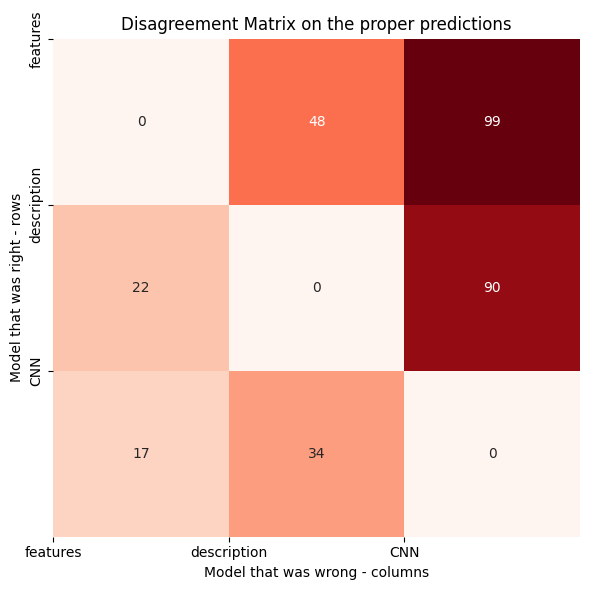

In [ ]:
disagreement_matrix = [
    [0, features_not_description, features_not_cnn],
    [description_not_features, 0, description_not_cnn],
    [cnn_not_features, cnn_not_description, 0]
]



names = ['features', 'description', 'CNN']

plt.figure(figsize=(6,6))
sns.heatmap(disagreement_matrix, annot=True, fmt="d", cmap="Reds", cbar=False)
plt.title("Disagreement Matrix on the proper predictions")
plt.ylabel("Model that was right - rows")
plt.xlabel("Model that was wrong - columns")
plt.xticks([0,1,2],names)
plt.yticks([0,1,2],names)
plt.tight_layout()
plt.savefig('disagreement.png')
plt.show()


# analysis by the class on the validation set

In [ ]:
exclusive = dev_df['label'] == 'cultural exclusive'
representative = dev_df['label'] == 'cultural representative'
agnostic = dev_df['label'] == 'cultural agnostic'

dict_mapping_classes = {
    'cultural agnostic': agnostic,
    'cultural exclusive' : exclusive,
    'cultural representative' : representative
}


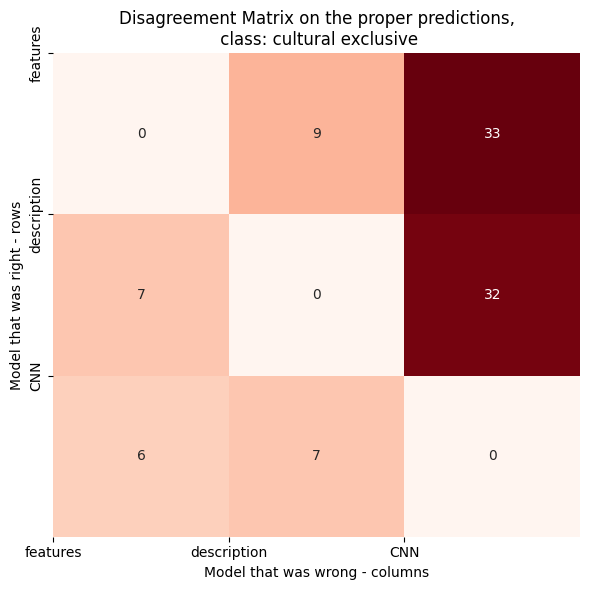

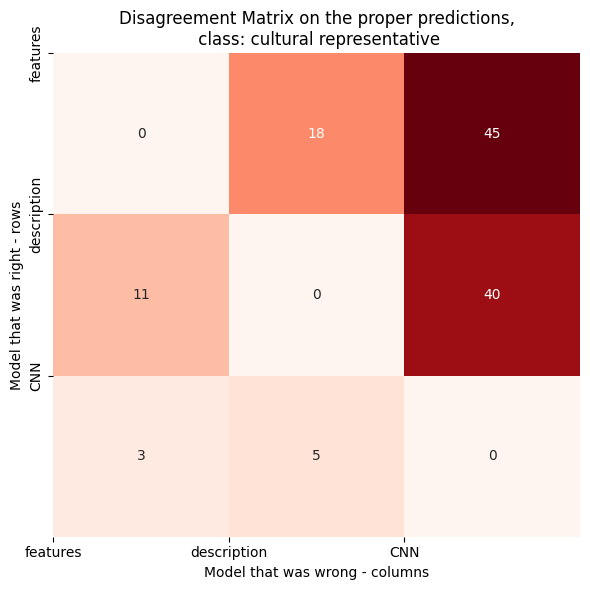

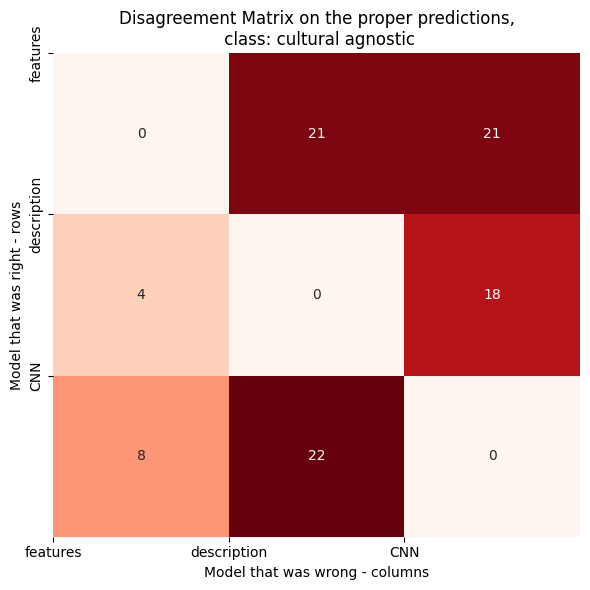

In [ ]:
labels = ['cultural exclusive', 'cultural representative','cultural agnostic']


features_classes_temp = features_classes.copy()
description_classes_temp = description_classes.copy()
photos_classes_temp = photos_classes.copy()

for indx, element in enumerate(labels):


    features_not_description =np.where((features_classes == true_classes) & (description_classes != true_classes))[0]
    description_not_features = np.where((features_classes != true_classes) & (description_classes == true_classes))[0]
    features_not_cnn = np.where((features_classes == true_classes) & (photos_classes != true_classes))[0]
    cnn_not_features = np.where((features_classes != true_classes) & (photos_classes == true_classes))[0]
    description_not_cnn = np.where((description_classes == true_classes) & (photos_classes != true_classes))[0]
    cnn_not_description = np.where((description_classes != true_classes) & (photos_classes == true_classes))[0]


    disagreement_matrix = [
        [0, features_not_description, features_not_cnn],
        [description_not_features, 0, description_not_cnn],
        [cnn_not_features, cnn_not_description, 0]
    ]
    for i in range(len(disagreement_matrix)):
      for j in range(len(disagreement_matrix[0])):
        if i ==j:
          continue

        disagreement_matrix[i][j] = np.intersect1d(disagreement_matrix[i][j], np.where(dict_mapping_classes[element])[0])
        disagreement_matrix[i][j] = len(disagreement_matrix[i][j])




    names = ['features', 'description', 'CNN']

    plt.figure(figsize=(6,6))
    sns.heatmap(disagreement_matrix, annot=True, fmt="d", cmap="Reds", cbar=False)
    plt.title(f"Disagreement Matrix on the proper predictions,\n class: {element}")
    plt.ylabel("Model that was right - rows")
    plt.xlabel("Model that was wrong - columns")
    plt.xticks([0,1,2],names)
    plt.yticks([0,1,2],names)
    plt.tight_layout()
    plt.savefig(f'disagreemennt_class_{element}.png')
    plt.show()

# Conclusions

It is clearly visible that none of the models dominates any other since there are no 0  in disagreement matrix apart from the diagonals. Therefore the usage of the ensemble with all 3 models could potentially prove beneficial to the performance of the cultural entity classification system.